This case study simulates a real-world marketing scenario aimed at optimizing resource allocation to maximize revenue. I built propensity models to predict customer purchase likelihood for three financial products: Consumer Loans (CL), Credit Cards (CC), and Mutual Funds (MF). The objective is to maximize revenue from direct marketing campaigns by targeting the right customers with the right products.
 
**Part 1: Model Training**
I trained and compared three different LightGBM binary classifiers:
1. A baseline model with manually tuned parameters and scaled class weights
2. A baseline model with manually tuned parameters and SMOTE resampling
3. An optimized model using Optuna for hyperparameter tuning, with:
   - ROC-AUC score minus 0.1 * Brier score as the optimization metric
   - Stratified 5-fold cross-validation for robust model evaluation and hyperparameter tuning
   - Scaled class weights for imbalanced target labels

**Part 2: Revenue Optimization**
Given constraints that only 15% of clients can be contacted and each client can receive only one product offer, I explored two targeting strategies:
1. Selecting top 15% of clients by expected revenue (probability * product revenue)
2. Selecting top 15% of clients by first finding highest propensity product per client, then ranking by expected revenue

Both approaches satisfies the goal of maximizing revenue. The first strategy achieved higher total expected revenue (**S$1,319 vs S$1,270**), but the second strategy provided better product diversity in recommendations while maintaining strong revenue potential. The choice, of course, is dependent on the goal of the business. Since the explicit goal of the task is to maximize revenue, then we will choose option 1. However, in general, I would argue that the second approach may be preferable in practice as it aligns better with typical marketing objectives of balanced product promotion while still driving significant revenue.

**Answers to Case Study Questions** <br>
The case study included several key questions about model performance, revenue optimization strategies, and business recommendations. Detailed answers and analysis for each question can be found at the end of this notebook.

In [260]:
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Imports
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn Utilities
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Hyperparameter Tuning
import optuna

# Models
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

# Custom Modules
from lib.train_functions import train_classifier #, evaluate_model_performance
from lib.optim_utils import save_params, load_params,  cross_validation
from lib.optim_functions import objective_lgbm

# Toggle off when not turning hyperparams (to not overwrite my existing parameter set)
TUNING_HYPERPARAM = False

In [2]:
X_base = pd.read_csv('./data/X.csv', index_col=0)
y_base = pd.read_csv('./data/y.csv', index_col=0)
df_sales_revenues = pd.read_excel('./data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Sales_Revenues')

### Data Preprocessing

#### Data Scaling / Normalization

In [3]:
# I plan to use tree-based model so I don't need to scale the data

# # Initialize and fit StandardScaler on X_base (excluding 'Client' column)
# scaler = StandardScaler()
# scalable_columns = X_base.columns[1:]
# X_base[scalable_columns] = scaler.fit_transform(X_base[scalable_columns])

#### Data Wrangling

In [4]:
# Extract clients with and without target labels (60% of dataset has labels)
sales_clients = set(df_sales_revenues.Client)
y = y_base[y_base.Client.isin(sales_clients)].reset_index(drop=True)  # 60% of data with target labels
y_hidden = y_base[~y_base.Client.isin(sales_clients)].reset_index(drop=True)  # 40% of data without target labels

X = X_base[X_base.Client.isin(sales_clients)].reset_index(drop=True)
X_hidden = X_base[~X_base.Client.isin(sales_clients)].reset_index(drop=True)

X_clients = X.Client
X_hidden_clients = X_hidden.Client

# Drop Client column
X = X.drop(columns=['Client'])
X_hidden = X_hidden.drop(columns=['Client'])

print(f'Shape of y: {y.shape}')
print(f'Shape of y_hidden: {y_hidden.shape}')
print(f'Shape of X: {X.shape}')
print(f'Shape of X_hidden: {X_hidden.shape}')


Shape of y: (969, 7)
Shape of y_hidden: (646, 7)
Shape of X: (969, 28)
Shape of X_hidden: (646, 28)


In [5]:
# Split the target labels into separate series for each product
y_MF = y.Sale_MF
y_CC = y.Sale_CC
y_CL = y.Sale_CL
y_hidden_MF = y_hidden.Sale_MF
y_hidden_CC = y_hidden.Sale_CC
y_hidden_CL = y_hidden.Sale_CL

print(f'Shape of y_MF: {y_MF.shape}')
print(f'Shape of y_CC: {y_CC.shape}')
print(f'Shape of y_CL: {y_CL.shape}')
print(f'Shape of y_hidden_MF: {y_hidden_MF.shape}')
print(f'Shape of y_hidden_CC: {y_hidden_CC.shape}')
print(f'Shape of y_hidden_CL: {y_hidden_CL.shape}')


Shape of y_MF: (969,)
Shape of y_CC: (969,)
Shape of y_CL: (969,)
Shape of y_hidden_MF: (646,)
Shape of y_hidden_CC: (646,)
Shape of y_hidden_CL: (646,)


### Model Training

For each product, train a **binary classification model**. I'll begin with establishing a baseline result first.

#### Base LGBM via manual tuning

In [6]:
# I'll collect my results here
models = {}
model_params = {}
roc_auc_scores = {}
propensity_scores = {}
propensity_scores_hidden = {}

target_product_data = [('MF', X, y_MF), ('CC', X, y_CC), ('CL', X, y_CL)]

In [7]:
for (tag, X_train, y_train) in target_product_data:

    # 1. Set training parameters
    model_params[f'base_{tag}'] = {'boosting_type': 'gbdt', 
                                    'objective': 'binary',
                                    'n_estimators': 200,
                                    'learning_rate': 0.05,
                                    'max_depth': 7,
                                    'colsample_bytree': 0.8,
                                    'subsample': 0.8,
                                    'random_state': 42}

    # 2. Train model, record scores
    clf = LGBMClassifier(verbose=-1, is_unbalance=True, **model_params[f'base_{tag}'])
    models[f'base_{tag}'], (_, _, _, _, roc_auc_scores[f'base_{tag}']) = train_classifier(clf, X_train, y_train)

    # 3. Calcualte propensity scores for the entire dataset (labelled 60% and hidden 40%)
    propensity_scores[f'base_{tag}'] = models[f'base_{tag}'].predict_proba(X)[:, 1]
    propensity_scores_hidden[f'base_{tag}'] = models[f'base_{tag}'].predict_proba(X_hidden)[:, 1]

    del clf


Model Performance on Validation Set:
-------------------------
Confusion Matrix:
[[121  33]
 [ 31   9]]
Precision Score: 0.2143
Recall Score: 0.2250
F1 Score: 0.2195
PR-AUC Score: 0.2579
ROC-AUC Score: 0.5429


Model Performance on Validation Set:
-------------------------
Confusion Matrix:
[[121  24]
 [ 32  17]]
Precision Score: 0.4146
Recall Score: 0.3469
F1 Score: 0.3778
PR-AUC Score: 0.4100
ROC-AUC Score: 0.6045


Model Performance on Validation Set:
-------------------------
Confusion Matrix:
[[102  38]
 [ 33  21]]
Precision Score: 0.3559
Recall Score: 0.3889
F1 Score: 0.3717
PR-AUC Score: 0.4128
ROC-AUC Score: 0.6234




#### LGBM with SMOTE via manual tuning

In [8]:
for (tag, X_train, y_train) in target_product_data:

    # 1. Set training parameters
    model_params[f'base_smote_{tag}'] = {'boosting_type': 'gbdt', 
                                        'objective': 'binary',
                                        'n_estimators': 200,
                                        'learning_rate': 0.05,
                                        'max_depth': 7,
                                        'colsample_bytree': 0.8,
                                        'subsample': 0.8,
                                        'random_state': 42}

    smote_params = {'sampling_strategy': 'minority',
                    'random_state': 42,
                    'k_neighbors': 5,
                    'n_jobs': -1}

    # 2. Train model, record scores
    clf = LGBMClassifier(verbose=-1, **model_params[f'base_smote_{tag}'])
    models[f'base_smote_{tag}'], (_, _, _, _, roc_auc_scores[f'base_smote_{tag}']) = train_classifier(clf, X_train, y_train, smote_resampling=True, smote_params=smote_params)

    # 3. Calcualte propensity scores for the entire dataset (labelled 60% and hidden 40%)
    propensity_scores[f'base_smote_{tag}'] = models[f'base_smote_{tag}'].predict_proba(X)[:, 1]
    propensity_scores_hidden[f'base_smote_{tag}'] = models[f'base_smote_{tag}'].predict_proba(X_hidden)[:, 1]

    del clf


Model Performance on Validation Set:
-------------------------
Confusion Matrix:
[[139  15]
 [ 33   7]]
Precision Score: 0.3182
Recall Score: 0.1750
F1 Score: 0.2258
PR-AUC Score: 0.2705
ROC-AUC Score: 0.5890


Model Performance on Validation Set:
-------------------------
Confusion Matrix:
[[126  19]
 [ 37  12]]
Precision Score: 0.3871
Recall Score: 0.2449
F1 Score: 0.3000
PR-AUC Score: 0.3910
ROC-AUC Score: 0.5717


Model Performance on Validation Set:
-------------------------
Confusion Matrix:
[[116  24]
 [ 36  18]]
Precision Score: 0.4286
Recall Score: 0.3333
F1 Score: 0.3750
PR-AUC Score: 0.4277
ROC-AUC Score: 0.6210




In [9]:
model_types = ['base', 'base_smote']
products = ['MF', 'CC', 'CL']

reshaped_scores = {model: [] for model in model_types}

for model in model_types:
    for product in products:
        key = f'{model}_{product}'
        score = roc_auc_scores.get(key, None)
        reshaped_scores[model].append(score)

# wide format
roc_auc_df = pd.DataFrame(reshaped_scores, index=products)
roc_auc_df.columns.name = 'Model Type'
roc_auc_df.index.name = 'Product'

print("ROC-AUC Scores for baseline Models:")
display(roc_auc_df)



ROC-AUC Scores for baseline Models:


Model Type,base,base_smote
Product,,
MF,0.542857,0.588961
CC,0.604504,0.571710
CL,0.623413,0.621032


### Hyperparameter Tuning with Optuna

##### Base LGBM via Optuna

In [10]:
if TUNING_HYPERPARAM:

    n_trials = 150
    timeout = 3600

    
    for (tag, X_train, y_train) in target_product_data:

        # 1. Use optuna to find the best hyperparameters for each product
        pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
        study = optuna.create_study(study_name=f'optuna_lgbm_{tag}', 
                                    direction='maximize',
                                    pruner=pruner)
        
        study.optimize(lambda trial: objective_lgbm(trial, X_train, y_train),
                       n_trials=n_trials,
                       timeout=timeout)

        print(f"Best trial for optuna_lgbm_{tag}:")
        print(f" Value: {study.best_value:.4f}")
        print("  Params: ")

        # save best params
        for key, value in study.best_params.items():
            print(f"    {key}: {value}")

        model_params[f'optuna_lgbm_{tag}'] = study.best_params
        save_params(model_params[f'optuna_lgbm_{tag}'], f'optuna_lgbm_{tag}')

        # 2. Train the model with the best hyperparameters, record scores
        clf = LGBMClassifier(**study.best_params,
                             n_jobs=-1,
                             verbosity=-1,
                             boosting_type="gbdt",
                             objective='binary',
                             random_state=42)
            
        models[f'optuna_lgbm_{tag}'], (_, _, _, _, roc_auc_scores[f'optuna_lgbm_{tag}']) = train_classifier(clf, X_train, y_train)

        # 3. Calculate propensity scores for the entire dataset (labelled 60% and hidden 40%)
        propensity_scores[f'optuna_lgbm_{tag}'] = models[f'optuna_lgbm_{tag}'].predict_proba(X)[:, 1]
        propensity_scores_hidden[f'optuna_lgbm_{tag}'] = models[f'optuna_lgbm_{tag}'].predict_proba(X_hidden)[:, 1]

        del pruner, study, clf



[I 2025-03-16 21:54:21,300] A new study created in memory with name: optuna_lgbm_MF
[I 2025-03-16 21:54:23,411] Trial 0 finished with value: 0.5820055922933669 and parameters: {'num_leaves': 212, 'learning_rate': 0.015559426877391471, 'n_estimators': 1118, 'min_child_samples': 80, 'reg_alpha': 0.0002701103107442754, 'reg_lambda': 0.0033982084975925407, 'colsample_bytree': 0.5373330342608562, 'subsample': 0.6234932470815588, 'max_depth': 10, 'feature_fraction': 0.7886377236227525, 'bagging_fraction': 0.693092501442425, 'bagging_freq': 6, 'scale_pos_weight': 1.251668810618693}. Best is trial 0 with value: 0.5820055922933669.
[I 2025-03-16 21:54:23,958] Trial 1 finished with value: 0.569595952122959 and parameters: {'num_leaves': 90, 'learning_rate': 0.04720799703709723, 'n_estimators': 231, 'min_child_samples': 58, 'reg_alpha': 0.00032444352930558384, 'reg_lambda': 0.03780230013161439, 'colsample_bytree': 0.9716350807607634, 'subsample': 0.8545525086213284, 'max_depth': -1, 'feature_frac

Best trial for optuna_lgbm_MF:
 Value: 0.6013
  Params: 
    num_leaves: 426
    learning_rate: 0.0057243665550469605
    n_estimators: 1725
    min_child_samples: 50
    reg_alpha: 0.00024010893519872486
    reg_lambda: 0.08134085430541234
    colsample_bytree: 0.5571392740417611
    subsample: 0.7073040251369256
    max_depth: 3
    feature_fraction: 0.6955649172301203
    bagging_fraction: 0.8581021023095012
    bagging_freq: 3
    scale_pos_weight: 0.974281520022902


[I 2025-03-16 22:05:19,141] A new study created in memory with name: optuna_lgbm_CC


Model Performance on Validation Set:
-------------------------
Confusion Matrix:
[[151   3]
 [ 38   2]]
Precision Score: 0.4000
Recall Score: 0.0500
F1 Score: 0.0889
PR-AUC Score: 0.2530
ROC-AUC Score: 0.5396




[I 2025-03-16 22:05:20,835] Trial 0 finished with value: 0.516916805012648 and parameters: {'num_leaves': 56, 'learning_rate': 0.17383736709448708, 'n_estimators': 747, 'min_child_samples': 73, 'reg_alpha': 0.3634609813495347, 'reg_lambda': 0.012420233497762802, 'colsample_bytree': 0.7713086085497174, 'subsample': 0.5723006902471033, 'max_depth': 10, 'feature_fraction': 0.8333531324665577, 'bagging_fraction': 0.4519176190977914, 'bagging_freq': 1, 'scale_pos_weight': 9.976648069157422}. Best is trial 0 with value: 0.516916805012648.
[I 2025-03-16 22:05:29,195] Trial 1 finished with value: 0.5605403079300713 and parameters: {'num_leaves': 429, 'learning_rate': 0.03702361116133192, 'n_estimators': 945, 'min_child_samples': 20, 'reg_alpha': 0.00245282483931855, 'reg_lambda': 0.008811918216630018, 'colsample_bytree': 0.807812097152893, 'subsample': 0.6990423672354465, 'max_depth': 10, 'feature_fraction': 0.9966897080562828, 'bagging_fraction': 0.8375424533920577, 'bagging_freq': 3, 'scale_

Best trial for optuna_lgbm_CC:
 Value: 0.5930
  Params: 
    num_leaves: 491
    learning_rate: 0.04879431851660135
    n_estimators: 109
    min_child_samples: 11
    reg_alpha: 0.0004656338713639158
    reg_lambda: 0.19880010597736317
    colsample_bytree: 0.5798155369492122
    subsample: 0.8688291615935523
    max_depth: -1
    feature_fraction: 0.832137256443156
    bagging_fraction: 0.5543136061773225
    bagging_freq: 1
    scale_pos_weight: 0.5994379385576114


[I 2025-03-16 22:17:55,484] A new study created in memory with name: optuna_lgbm_CL


Model Performance on Validation Set:
-------------------------
Confusion Matrix:
[[142   3]
 [ 42   7]]
Precision Score: 0.7000
Recall Score: 0.1429
F1 Score: 0.2373
PR-AUC Score: 0.4391
ROC-AUC Score: 0.6236




[I 2025-03-16 22:18:02,598] Trial 0 finished with value: 0.6020342864957846 and parameters: {'num_leaves': 82, 'learning_rate': 0.01604665491435046, 'n_estimators': 1892, 'min_child_samples': 65, 'reg_alpha': 0.003862107585151001, 'reg_lambda': 0.0018801592181576278, 'colsample_bytree': 0.8719578445968021, 'subsample': 0.6592192033687587, 'max_depth': 10, 'feature_fraction': 0.47431912046859337, 'bagging_fraction': 0.8121420792969902, 'bagging_freq': 1, 'scale_pos_weight': 5.672240428200834}. Best is trial 0 with value: 0.6020342864957846.
[I 2025-03-16 22:18:03,166] Trial 1 finished with value: 0.6235330270339426 and parameters: {'num_leaves': 216, 'learning_rate': 0.007371092707550052, 'n_estimators': 365, 'min_child_samples': 96, 'reg_alpha': 0.00025930776307671777, 'reg_lambda': 0.0003189986014279845, 'colsample_bytree': 0.7246240174095208, 'subsample': 0.9540443151188882, 'max_depth': 10, 'feature_fraction': 0.9065250800112338, 'bagging_fraction': 0.4001277196331543, 'bagging_freq

Best trial for optuna_lgbm_CL:
 Value: 0.6677
  Params: 
    num_leaves: 216
    learning_rate: 0.03315396185923432
    n_estimators: 347
    min_child_samples: 10
    reg_alpha: 0.0008959071753598509
    reg_lambda: 0.014006718722084059
    colsample_bytree: 0.5295966713579825
    subsample: 0.874832401312016
    max_depth: 3
    feature_fraction: 0.6561260982050167
    bagging_fraction: 0.8812261620528629
    bagging_freq: 5
    scale_pos_weight: 0.6259430973845609
Model Performance on Validation Set:
-------------------------
Confusion Matrix:
[[130  10]
 [ 44  10]]
Precision Score: 0.5000
Recall Score: 0.1852
F1 Score: 0.2703
PR-AUC Score: 0.4294
ROC-AUC Score: 0.6614




### Revenue Optimization

As mentioned in the EDA notebook:

Given the dataset characteristics (high sparsity, skewed distributions, and limited revenue data), I believe a reliable yet simple approach is to use an estimated average revenue per sale for each of the 3 products:

Expected revenue = $P_{i,j} \times$ Avg Revenue Per Sale for Product $j$

where:
- $P_{i,j}$ = propensity score for product $j$
- Avg Revenue Per Sale is computed from nonzero revenue values in y.csv

#### Calculate Estimated Revenue per Client per Product

In [298]:
benchmark_models = ['base', 'base_smote', 'optuna_lgbm'] #, 'optuna_lgbm_smote']
product_tags = ['MF', 'CC', 'CL']

In [299]:
# Calculate and compile propensity scores P_(i,j)
# Create dataframes with propensity scores
propensity_scores_df = pd.DataFrame(propensity_scores)
propensity_scores_df.insert(0, 'Client', X_clients)
propensity_scores_hidden_df = pd.DataFrame(propensity_scores_hidden)
propensity_scores_hidden_df.insert(0, 'Client', X_hidden_clients)


In [300]:
propensity_scores_all = pd.concat([propensity_scores_df, propensity_scores_hidden_df]).sort_values(by='Client').reset_index(drop=True)

print("Propensity Scores for all clients across all models:")
propensity_scores_all

Propensity Scores for all clients across all models:


,Client,base_MF,base_CC,base_CL,base_smote_MF,base_smote_CC,base_smote_CL,optuna_lgbm_MF,optuna_lgbm_CC,optuna_lgbm_CL,optuna_lgbm_smote_MF
0,1,0.889023,0.051038,0.121428,0.802593,0.038383,0.087628,0.464600,0.019637,0.113552,0.671269
1,2,0.075447,0.056910,0.153408,0.095035,0.083088,0.240559,0.095267,0.022124,0.113244,0.176375
2,3,0.134368,0.090663,0.328532,0.131349,0.132822,0.414797,0.167399,0.060459,0.229433,0.231275
3,4,0.082022,0.304514,0.844768,0.130431,0.060605,0.715040,0.137938,0.125903,0.731259,0.235701
4,5,0.191639,0.114424,0.683505,0.137414,0.055262,0.676416,0.271310,0.082659,0.448055,0.269859
...,...,...,...,...,...,...,...,...,...,...,...
1610,1611,0.204125,0.070441,0.544182,0.200534,0.139703,0.483995,0.126406,0.102175,0.494167,0.415681
1611,1612,0.038790,0.053532,0.054577,0.016706,0.041228,0.076362,0.149920,0.021314,0.068034,0.115098
1612,1613,0.347393,0.332835,0.193246,0.442417,0.220176,0.328827,0.234410,0.092066,0.107724,0.358494
1613,1614,0.429335,0.130359,0.552232,0.456168,0.267422,0.498632,0.200413,0.125599,0.326439,0.357235


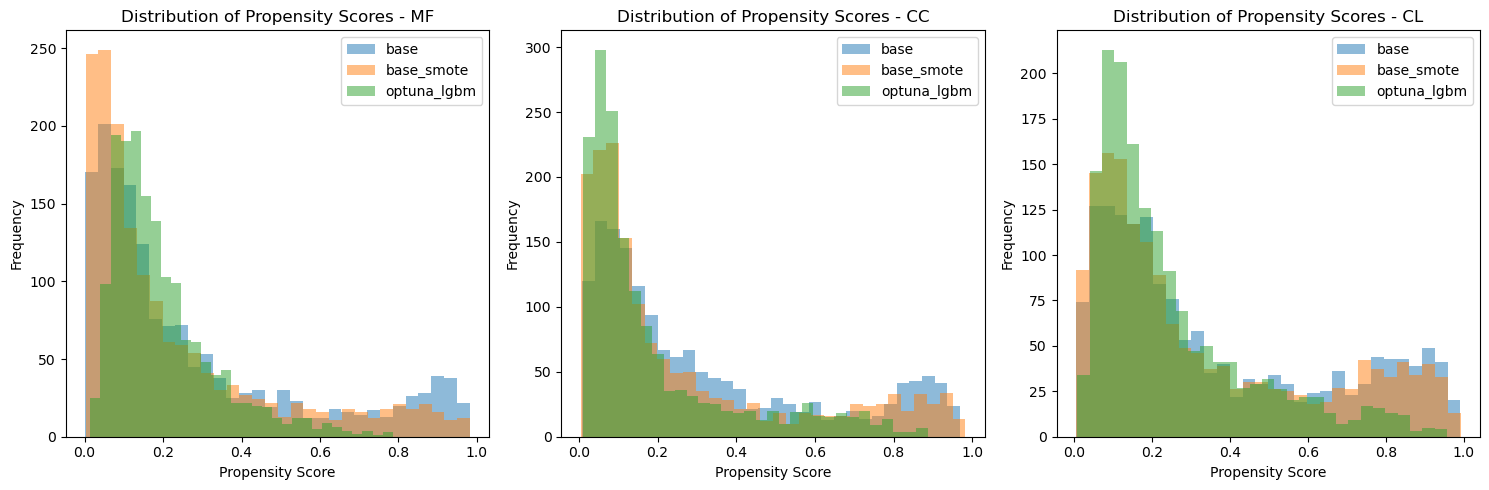

In [301]:
# Let's plot the distribution of propensity scores across products to see how our models assigned the propensity scores
plt.figure(figsize=(15,5))

# Plot histograms for each product type
for i, tag in enumerate(product_tags):
    plt.subplot(1,3,i+1)
    for model in benchmark_models:
        plt.hist(propensity_scores_all[f'{model}_{tag}'], 
                alpha=0.5, 
                bins=30,
                label=model)
    plt.title(f'Distribution of Propensity Scores - {tag}')
    plt.xlabel('Propensity Score')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

In [302]:
# Compute average revenue per sale

avg_revenue_per_sale = {
    "Sale_MF": y["Revenue_MF"][y["Revenue_MF"] > 0].mean(),
    "Sale_CC": y["Revenue_CC"][y["Revenue_CC"] > 0].mean(), 
    "Sale_CL": y["Revenue_CL"][y["Revenue_CL"] > 0].mean()
}

avg_revenue_per_sale

{'Sale_MF': 9.66497409326425,
 'Sale_CC': 10.862516233766236,
 'Sale_CL': 12.043066502463045}

In [303]:
# Calculate expected revenue across models in benchmark_models
revenue_multipliers = {}

# Map average revenue per sale to corresponding columns in propensity_scores_df
for tag in product_tags:
    revenue = avg_revenue_per_sale[f'Sale_{tag}']
    matching_cols = [col for col in propensity_scores_all.columns if tag in col]

    for col in matching_cols:
        revenue_multipliers[col] = revenue

# propensity x average revenue per sale
expected_revenue = propensity_scores_all.copy()
expected_revenue.iloc[:, 1:] = propensity_scores_all.iloc[:, 1:].mul(revenue_multipliers)

expected_revenue

,Client,base_MF,base_CC,base_CL,base_smote_MF,base_smote_CC,base_smote_CL,optuna_lgbm_MF,optuna_lgbm_CC,optuna_lgbm_CL,optuna_lgbm_smote_MF
0,1,8.592384,0.554402,1.462363,7.757041,0.416937,1.055316,4.490349,0.213312,1.367519,6.487801
1,2,0.729194,0.618191,1.847501,0.918515,0.902543,2.897066,0.920752,0.240323,1.363800,1.704658
2,3,1.298661,0.984829,3.956536,1.269489,1.442779,4.995430,1.617905,0.656738,2.763075,2.235270
3,4,0.792738,3.307791,10.173601,1.260612,0.658325,8.611276,1.333167,1.367626,8.806595,2.278041
4,5,1.852188,1.242930,8.231493,1.328107,0.600287,8.146119,2.622204,0.897887,5.395952,2.608176
...,...,...,...,...,...,...,...,...,...,...,...
1610,1611,1.972859,0.765164,6.553621,1.938160,1.517527,5.828786,1.221715,1.109874,5.951283,4.017551
1611,1612,0.374908,0.581490,0.657278,0.161466,0.447845,0.919631,1.448978,0.231526,0.819334,1.112421
1612,1613,3.357545,3.615421,2.327275,4.275954,2.391664,3.960090,2.265568,1.000070,1.297333,3.464834
1613,1614,4.149514,1.416025,6.650562,4.408854,2.904871,6.005060,1.936990,1.364320,3.931324,3.452665


In [304]:
# Split expected revenue by model
expected_revenue_by_model = {}
for model_prefix in benchmark_models:
    model_columns = [col for col in expected_revenue.columns if model_prefix == "_".join(col.split('_')[:-1]) or col == 'Client']
    #renamed_columns_rev = {col: f"{col}_rev" if col != 'Client' else col for col in model_columns}
    expected_revenue_by_model[model_prefix] = expected_revenue[model_columns] #.rename(columns=renamed_columns_rev)

# Split propensity scores by model
propensity_scores_by_model = {}
for model_prefix in benchmark_models:
    model_columns = [col for col in propensity_scores_df.columns if model_prefix == "_".join(col.split('_')[:-1]) or col == 'Client']
    #renamed_columns_prop = {col: f"{col}_prop" if col != 'Client' else col for col in model_columns}
    propensity_scores_by_model[model_prefix] = propensity_scores_df[model_columns] #.rename(columns=renamed_columns_prop)


#### Selecting our Top 15%

The goal of this analysis is to identify a Target Client list containing the top 15% of clients that the bank should prioritize for outreach.

We can generate this list using two different approaches:

1. Select clients based on highest **Expected Revenue**
   - This approach prioritizes clients with highest potential revenue (Propensity × Average Sale Price)
   - May identify fewer but higher-value opportunities
   - Higher risk but potentially higher reward since this approach may trade-off propensity over higher expected revenue outcomes 

2. Select clients based on highest **Propensity Scores**
   - This approach prioritizes clients most likely to purchase, regardless of purchase price
   - Provides more certainty that selected clients will convert
   - Lower risk approach since we focus on likelihood of success

As a Data Scientist, aligning the selection approach with business objectives is crucial.

##### Top 15% by expected revenue
For instance, let's say after discussion with stakeholders, we decided to proceed with Option 1 (Expected Revenue) to maximize potential revenue, accepting the associated higher risk profile.

In [305]:
top_15_len = int(len(X) * 0.15)
top_15_len

145

In [306]:

top_15_pct_by_revenue = {}
total_expected_revenue = {}

# For each client, identify the best offer by estimate revenue (propensity x price) per product
for model_prefix in benchmark_models:
    expected_revenue_df = expected_revenue_by_model[model_prefix]
    expected_revenue_by_model[model_prefix][f'{model_prefix}_best_offer'] = expected_revenue_df.loc[:, [f'{model_prefix}_MF', f'{model_prefix}_CC', f'{model_prefix}_CL']].idxmax(axis=1)
    expected_revenue_by_model[model_prefix][f"{model_prefix}_max_revenue"] = expected_revenue_df.loc[:, [f'{model_prefix}_MF', f'{model_prefix}_CC', f'{model_prefix}_CL']].max(axis=1)

# sample
expected_revenue_by_model['optuna_lgbm'].head()

,Client,optuna_lgbm_MF,optuna_lgbm_CC,optuna_lgbm_CL,optuna_lgbm_best_offer,optuna_lgbm_max_revenue
0,1,4.490349,0.213312,1.367519,optuna_lgbm_MF,4.490349
1,2,0.920752,0.240323,1.363800,optuna_lgbm_CL,1.363800
2,3,1.617905,0.656738,2.763075,optuna_lgbm_CL,2.763075
3,4,1.333167,1.367626,8.806595,optuna_lgbm_CL,8.806595
4,5,2.622204,0.897887,5.395952,optuna_lgbm_CL,5.395952


In [307]:
# Find the top 15% of clients based on max expected revenue per client
for model_prefix in benchmark_models:
    top_15_pct_by_revenue[model_prefix] = expected_revenue_by_model[model_prefix].sort_values(by=f"{model_prefix}_max_revenue", ascending=False) \
                                                                   .head(top_15_len) \
                                                                   .loc[:, ["Client", f"{model_prefix}_best_offer", f"{model_prefix}_max_revenue"]] \
                                                                   .reset_index(drop=True)

# sample
top_15_pct_by_revenue['optuna_lgbm'].head()

,Client,optuna_lgbm_best_offer,optuna_lgbm_max_revenue
0,23,optuna_lgbm_CL,11.516337
1,1499,optuna_lgbm_CL,11.428176
2,1231,optuna_lgbm_CL,11.390346
3,102,optuna_lgbm_CL,11.246131
4,350,optuna_lgbm_CL,11.122299


In [308]:
# Calculate total expected revenue for each model in our benchmark
total_revenue_df = pd.DataFrame({
    'Model': benchmark_models,
    'Total Expected Revenue': [top_15_pct_by_revenue[model].iloc[:, -1].sum() 
                             for model in benchmark_models]
})
total_revenue_df

,Model,Total Expected Revenue
0,base,1605.581954
1,base_smote,1584.806025
2,optuna_lgbm,1319.293814


How are the product offers distributed across different models in our benchmark?

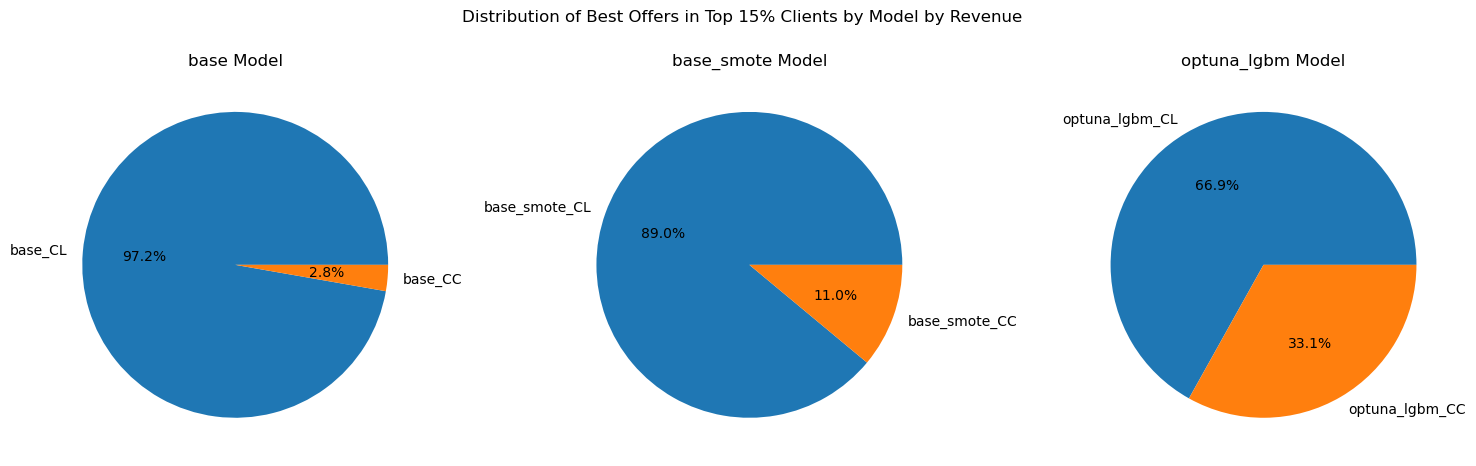

In [309]:
# Plot value counts on a pie chart
fig, axes = plt.subplots(1, len(benchmark_models), figsize=(15, 5))
fig.suptitle('Distribution of Best Offers in Top 15% Clients by Model by Revenue')

for i, model_prefix in enumerate(benchmark_models):

    offer_counts = top_15_pct_by_revenue[model_prefix][f'{model_prefix}_best_offer'].value_counts()
    
    axes[i].pie(offer_counts.values, labels=offer_counts.index, autopct='%1.1f%%')
    axes[i].set_title(f'{model_prefix} Model')

plt.tight_layout()
plt.show()

While the 'base' model achieved the highest expected revenue, the pie charts reveal that over 97% of its product recommendations were Consumer Loans (CL). In contrast, the Optuna-tuned LGBM model produced a more balanced marketing strategy, with Credit Cards (CC) comprising 33% of recommendations.

This highlights a key limitation of optimizing solely for revenue: it can lead to a lack of product diversity in recommendations. Since expected revenue in this approach is calculated by multiplying propensity scores with sale prices, simpler models that produce inflated probability estimates (and thus higher propensity scores) can artificially inflate the expected revenue calculations, even if their predictions are less reliable.

Furthermore, this strategy is also more sensitive to disparity is average sale prices. It's worth noting that none of the models recommended Mutual Funds (MF) in their top suggestions, given that MF produce the least revenue per unit than the other two products, and hence, will yield overall lower expected revenue values.

##### Top 15% by Revenue & Propensity

Let's explore an alternative approach where we prioritize customer conversion likelihood first, and then consider revenue potential. This shift in strategy could be valuable if stakeholders want to focus on building a broader customer base before maximizing revenue per sale.

In [310]:
top_15_pct_by_prop = {}
total_expected_prop = {}

# For each client, identify the best offer by propensity
for model_prefix in benchmark_models:
    propensity_scores_df = propensity_scores_by_model[model_prefix]
    propensity_scores_by_model[model_prefix][f'{model_prefix}_best_offer'] = propensity_scores_df.loc[:, [f'{model_prefix}_MF', f'{model_prefix}_CC', f'{model_prefix}_CL']].idxmax(axis=1)
    propensity_scores_by_model[model_prefix][f"{model_prefix}_max_prop"] = propensity_scores_df.loc[:, [f'{model_prefix}_MF', f'{model_prefix}_CC', f'{model_prefix}_CL']].max(axis=1)

# sample
propensity_scores_by_model['optuna_lgbm'].head()

,Client,optuna_lgbm_MF,optuna_lgbm_CC,optuna_lgbm_CL,optuna_lgbm_best_offer,optuna_lgbm_max_prop
0,1,0.464600,0.019637,0.113552,optuna_lgbm_MF,0.464600
1,2,0.095267,0.022124,0.113244,optuna_lgbm_CL,0.113244
2,6,0.083135,0.030024,0.167260,optuna_lgbm_CL,0.167260
3,8,0.305749,0.181168,0.191437,optuna_lgbm_MF,0.305749
4,13,0.141610,0.014384,0.060463,optuna_lgbm_MF,0.141610


In [311]:
# Find the top 15% of clients based on propensity per client
for model_prefix in benchmark_models:
    top_15_pct_by_prop[model_prefix] = propensity_scores_by_model[model_prefix].sort_values(by=f"{model_prefix}_max_prop", ascending=False) \
                                                                   .head(top_15_len) \
                                                                   .loc[:, ["Client", f"{model_prefix}_best_offer", f"{model_prefix}_max_prop"]] \
                                                                   .reset_index(drop=True)

# sample
top_15_pct_by_prop['optuna_lgbm'].head()

,Client,optuna_lgbm_best_offer,optuna_lgbm_max_prop
0,23,optuna_lgbm_CL,0.956263
1,1499,optuna_lgbm_CL,0.948942
2,1231,optuna_lgbm_CL,0.945801
3,102,optuna_lgbm_CL,0.933826
4,316,optuna_lgbm_CL,0.912216


In [312]:
# Isolate the product tpye
for model_type in benchmark_models:
    top_15_pct_by_prop[model_type]['product'] = top_15_pct_by_prop[model_type].iloc[:, 1].apply(lambda x: x.split('_')[-1])

# Calculate expected revenue
for model_type in benchmark_models:
    top_15_pct_by_prop[model_type]['expected_revenue'] = top_15_pct_by_prop[model_type].apply(lambda x: x[f'{model_type}_max_prop'] * avg_revenue_per_sale[f'Sale_{x["product"]}'], axis=1)

top_15_pct_by_prop['optuna_lgbm']

,Client,optuna_lgbm_best_offer,optuna_lgbm_max_prop,product,expected_revenue
0,23,optuna_lgbm_CL,0.956263,CL,11.516337
1,1499,optuna_lgbm_CL,0.948942,CL,11.428176
2,1231,optuna_lgbm_CL,0.945801,CL,11.390346
3,102,optuna_lgbm_CL,0.933826,CL,11.246131
4,316,optuna_lgbm_CL,0.912216,CL,10.985884
...,...,...,...,...,...
140,898,optuna_lgbm_CC,0.671481,CC,7.293972
141,890,optuna_lgbm_CC,0.668739,CC,7.264187
142,990,optuna_lgbm_CL,0.667590,CL,8.039825
143,1408,optuna_lgbm_CC,0.666686,CC,7.241891


In [313]:
# Calculate total expected revenue for each model in our benchmark
total_revenue_by_prop_df = pd.DataFrame({
    'Model': benchmark_models,
    'Total Expected Revenue': [top_15_pct_by_prop[model].iloc[:, -1].sum() 
                             for model in benchmark_models]
})
total_revenue_by_prop_df

,Model,Total Expected Revenue
0,base,1502.846466
1,base_smote,1522.047484
2,optuna_lgbm,1270.070479


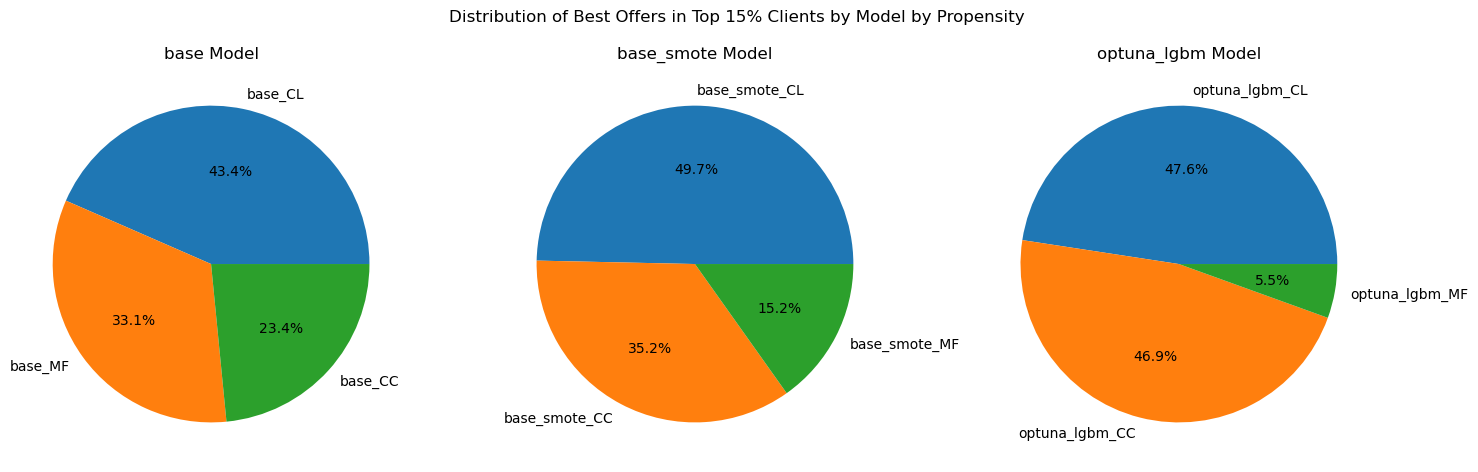

In [314]:
# Plot value counts on a pie chart
fig, axes = plt.subplots(1, len(benchmark_models), figsize=(15, 5))
fig.suptitle('Distribution of Best Offers in Top 15% Clients by Model by Propensity')

for i, model_prefix in enumerate(benchmark_models):

    offer_counts = top_15_pct_by_prop[model_prefix][f'{model_prefix}_best_offer'].value_counts()
    
    axes[i].pie(offer_counts.values, labels=offer_counts.index, autopct='%1.1f%%')
    axes[i].set_title(f'{model_prefix} Model')

plt.tight_layout()
plt.show()

By prioritizing propensity scores first before maximizing expected revenue, we take a more nuanced approach to product recommendations. This strategy considers the likelihood of client interest first, even if it means recommending lower-value products. The propensity-first approach offers several key advantages over purely revenue-driven recommendations:

1. More realistic product mix: The recommendations reflect a natural diversity of products that better matches real-world purchasing patterns, rather than being artificially skewed toward high-value products

2. Better product-market fit: By leading with propensity, we ensure products are well-matched to client preferences and needs, increasing the likelihood of successful sales

3. Reduced business risk: This approach:
   - Lowers the risk of customer dissatisfaction from mismatched recommendations
   - Creates more sustainable long-term customer relationships
   - Provides more stable revenue streams across the product portfolio

4. Higher conversion potential: While individual sale values may be lower, the increased likelihood of purchase can lead to better overall performance

### Direct Answers to Submission Questions

For these questions, I will be using the results of the Optuna_LGBM model as I believe the result of this approach yields better propensity estimates based on the ROC-AUC + Brier Score metric we used to optimize for the best performing model.

I will also be choosing the results from the first approach where we selected the top 15% by order of expected revenue.

In [315]:
# Which clients have a higher propensity to buy a consumer loan?

print('Top 100 clients by propensity to buy consumer loan')
propensity_scores_by_model['optuna_lgbm'].sort_values(by='optuna_lgbm_CL', ascending=False).iloc[:100,:].loc[:, ['Client', 'optuna_lgbm_CL']].reset_index(drop=True)

Top 100 clients by propensity to buy consumer loan


,Client,optuna_lgbm_CL
0,23,0.956263
1,1499,0.948942
2,1231,0.945801
3,102,0.933826
4,316,0.912216
...,...,...
95,1121,0.601736
96,384,0.598344
97,1268,0.597609
98,179,0.595496


In [316]:
# Which clients have a higher propensity to buy a credit card?

print('Top 100 clients by propensity to buy credit card')
propensity_scores_by_model['optuna_lgbm'].sort_values(by='optuna_lgbm_CC', ascending=False).iloc[:100,:].loc[:, ['Client', 'optuna_lgbm_CC']].reset_index(drop=True)

Top 100 clients by propensity to buy credit card


,Client,optuna_lgbm_CC
0,478,0.887494
1,938,0.883115
2,68,0.879180
3,1554,0.875756
4,1170,0.874338
...,...,...
95,271,0.611912
96,982,0.611647
97,127,0.610225
98,1505,0.609098


In [317]:
# Which clients have a higher propensity to buy a mutual fund?

print('Top 100 clients by propensity to buy mutual funds')
propensity_scores_by_model['optuna_lgbm'].sort_values(by='optuna_lgbm_MF', ascending=False).iloc[:100,:].loc[:, ['Client', 'optuna_lgbm_MF']].reset_index(drop=True)

Top 100 clients by propensity to buy mutual funds


,Client,optuna_lgbm_MF
0,1135,0.785256
1,390,0.764490
2,1149,0.758507
3,437,0.731081
4,1212,0.730613
...,...,...
95,1070,0.393882
96,122,0.388347
97,1180,0.385542
98,1325,0.383966


In [318]:
# Which clients are to be targeted with which offer?
top_15_pct_by_revenue['optuna_lgbm']

,Client,optuna_lgbm_best_offer,optuna_lgbm_max_revenue
0,23,optuna_lgbm_CL,11.516337
1,1499,optuna_lgbm_CL,11.428176
2,1231,optuna_lgbm_CL,11.390346
3,102,optuna_lgbm_CL,11.246131
4,350,optuna_lgbm_CL,11.122299
...,...,...,...
140,327,optuna_lgbm_CL,7.848834
141,477,optuna_lgbm_CL,7.842884
142,117,optuna_lgbm_CL,7.833480
143,568,optuna_lgbm_CC,7.810646


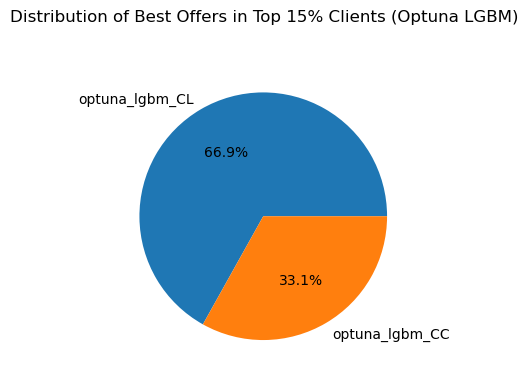

In [319]:
fig, ax = plt.subplots(figsize=(4, 4))
fig.suptitle('Distribution of Best Offers in Top 15% Clients (Optuna LGBM)')

model_prefix = 'optuna_lgbm'
offer_counts = top_15_pct_by_revenue[model_prefix][f'{model_prefix}_best_offer'].value_counts()

ax.pie(offer_counts.values, labels=offer_counts.index, autopct='%1.1f%%')

plt.tight_layout()
plt.show()

In [320]:
# What would be the expected revenue based on your strategy?
total_revenue_df[total_revenue_df.Model == 'optuna_lgbm']

,Model,Total Expected Revenue
2,optuna_lgbm,1319.293814
